In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification

In [4]:
from gensim.models import Word2Vec

In [39]:
from ml_utils import MultiLabelClassification

In [5]:
sys.path.append("../scripts/")
from mlsol import MLSOL

# Data preprocessing

The lyrics are tokenized, then converted into sequences to generate a zero-padded $n$-by-$m$ feature matrix $X$ where $n$ is the number of songs and $m$ is the maximum token length (word count) among songs.

In [6]:
df = pd.read_csv("../songs-ml-10pct.csv")[::10]

In [7]:
df.lyrics.str.split().apply(len).describe()

count    5818.000000
mean      167.685115
std        87.712091
min         3.000000
25%       112.000000
50%       156.000000
75%       209.000000
max      2018.000000
Name: lyrics, dtype: float64

In [8]:
input_length = df.lyrics.str.split().apply(len).max()

In [9]:
for col in df.columns[1:]:
    print(f"{col}: {100*df[col].mean():.2g}%")

black: 17%
death: 34%
heavy: 16%
power: 20%
thrash: 18%


In [49]:
X = df.lyrics.values
y = df[df.columns[1:]].values
num_labels = y.shape[1]
labels = df.columns[1:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Glove pre-trained word embeddings

In [12]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\'')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.index_word) + 1
print(vocab_size)

28596


In [13]:
def texts_to_sequences(texts, maxlen=input_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    return padded

In [14]:
padded_train = texts_to_sequences(X_train)
padded_test = texts_to_sequences(X_test)

In [15]:
padded_train.shape

(4654, 2018)

In [16]:
padded_train

array([[ 2155,    31,   382, ...,     0,     0,     0],
       [  127,   479,    22, ...,     0,     0,     0],
       [   11,    11,   137, ...,     0,     0,     0],
       ...,
       [28527, 28528,  8030, ...,     0,     0,     0],
       [    7,   488,   216, ...,     0,     0,     0],
       [  349,  7186,     6, ...,     0,     0,     0]])

### Resize sequences to a more manageable length

In [17]:
def resize_sequences(X_old, y_old, length):
    X_new = []
    y_new = []
    for i, row in enumerate(X_old):
        new_rows = np.split(row, np.arange(0, len(row), length))[1:]
        for new_row in new_rows:
            new_row_padded = np.pad(new_row, (0, input_length_short - len(new_row)))
            if sum(new_row_padded) > 0:
                X_new.append(new_row_padded)
                y_new.append(y_old[i])
    X_new = np.array(X_new)
    y_new = np.array(y_new)
    return X_new, y_new

In [18]:
input_length_short = 100
padded_train, y_train = resize_sequences(padded_train, y_train, input_length_short)
padded_test, y_test = resize_sequences(padded_test, y_test, input_length_short)

In [19]:
print(padded_train.shape, y_train.shape, padded_test.shape, y_test.shape)

(10312, 100) (10312, 5) (2568, 100) (2568, 5)


### Load word vectors into a dictionary

Adapted from [a Keras tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/).

In [20]:
# path_to_glove_file = "E:/Projects/metallyrics/data/glove.840B.300d.txt"
path_to_glove_file = "E:/Projects/metallyrics/data/glove.6B.100d.txt"

embedding_vectors = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_vectors[word] = coefs
print(len(embedding_vectors))
print(len(list(embedding_vectors.values())[0]))

400001
100


### Embedding matrix

In [21]:
embedding_dim = len(list(embedding_vectors.values())[0])
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) > 0:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
            continue
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 22918 words (5677 misses)


In [22]:
embedding_matrix.shape

(28596, 100)

In [24]:
embedding_layer = layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Data augmentation

To increase the number of training samples, the data can be augmented to generate new observations similar to existing ones. This can be done in a few ways:

1) Word replacement: replacing words with similar ones is straightforward, and preserves syntax and semantics if the new words are similar enough. However, it requires computing a lot of word vector distances, and oftentimes the replacement is the just a different conjugation of a verb, which breaks grammatical rules.

2) Backtranslation: translating a sequences into another language takes advantage of the fact that machine translators are good but not quite perfect. A backtranslated sequence will still be grammatically correct, but have differences in wording and syntax. 

#### Word replacement

In [35]:
vector = embedding_vectors['satan']
# dist = np.linalg.norm(embedding_matrix - vector, axis=1)
dist = -np.dot(embedding_matrix, vector)
nearest = [(tokenizer.index_word.get(i, 0), dist[i]) for i in  dist.argsort()[1:11]]
nearest

[('god', -19.013266124371704),
 ('evil', -16.74109671214331),
 ('devil', -16.391001127660708),
 ('jesus', -16.09329618071708),
 ('christ', -16.062787387783878),
 ('sacrifice', -14.433605984472056),
 ('heaven', -14.177968450023208),
 ('witches', -14.173267745378634),
 ('allah', -14.02747231518036),
 ('gods', -14.01646492569156)]

In [36]:
from nltk.corpus import stopwords

In [37]:
ignore = stopwords.words('english')

In [38]:
np.linalg.norm(embedding_matrix, axis=1)

array([0.        , 5.82115365, 6.29686884, ..., 4.24209435, 5.53236642,
       3.58112028])

In [39]:
def get_nearest_word(word, method='euclidean'):
    if word not in ignore and isinstance(word, str):
        if word in embedding_vectors.keys():
            vector = embedding_vectors[word]
            if len(vector) > 0:
                if method == 'euclidean':
                    dist = np.linalg.norm(embedding_matrix - vector, axis=1)
                    i = dist.argsort()[1]
                elif method == 'cosine':
                    embedding_norm = np.linalg.norm(embedding_matrix, axis=1)
                    vector_norm = np.linalg.norm(vector)
                    dist = np.dot(embedding_matrix, vector) / (embedding_norm * vector_norm)
                    dist = np.nan_to_num(dist, 0)
                    i = dist.argsort()[-2]
                else:
                    assert ValueError(f"invalid method {method}")
                nearest = tokenizer.index_word.get(i, 0)
                if nearest not in ignore:
                    return nearest
    return word

In [40]:
words = [tokenizer.index_word.get(i, 0) for i in padded_train[111]]
new_words = [get_nearest_word(word, 'cosine') for word in words]
new_row = [tokenizer.word_index.get(word, 0) for word in new_words]
print(words[:20])
print(new_words[:20])

C:\Users\philn\AppData\Local\Temp\ipykernel_16572\3763140851.py:12: RuntimeWarning: invalid value encountered in true_divide
  dist = np.dot(embedding_matrix, vector) / (embedding_norm * vector_norm)


['deep', 'in', 'the', 'angry', 'city', 'the', 'hatred', 'starts', 'to', 'wake', 'you', 'and', 'the', 'boys', 'and', 'their', 'turf', 'another', 'chance', 'to']
['deeper', 'in', 'the', 'furious', 'town', 'the', 'hostility', 'begins', 'to', 'aftermath', 'you', 'and', 'the', 'girls', 'and', 'their', 'grass', 'another', 'chances', 'to']


### Convolution neural network

In [131]:
model = Sequential()
model.add(embedding_layer)
model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         2859600   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                      

In [132]:
history = model.fit(padded_train, y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=1)
y_pred = model.predict(padded_test)
loss, acc = model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {loss:.4f}\nacc: {acc:.4f}")

Epoch 1/64
258/258 [==============================] - 2s 6ms/step - loss: 0.5040 - accuracy: 0.2754 - val_loss: 0.4989 - val_accuracy: 0.2899
Epoch 2/64
258/258 [==============================] - 1s 6ms/step - loss: 0.4758 - accuracy: 0.3111 - val_loss: 0.4902 - val_accuracy: 0.2991
Epoch 3/64
258/258 [==============================] - 1s 5ms/step - loss: 0.4596 - accuracy: 0.3385 - val_loss: 0.4823 - val_accuracy: 0.3078
Epoch 4/64
258/258 [==============================] - 1s 5ms/step - loss: 0.4457 - accuracy: 0.3672 - val_loss: 0.4809 - val_accuracy: 0.3388
Epoch 5/64
258/258 [==============================] - 1s 5ms/step - loss: 0.4333 - accuracy: 0.3901 - val_loss: 0.4740 - val_accuracy: 0.3330
Epoch 6/64
258/258 [==============================] - 1s 5ms/step - loss: 0.4216 - accuracy: 0.4148 - val_loss: 0.4723 - val_accuracy: 0.3393
Epoch 7/64
258/258 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.4299 - val_loss: 0.4693 - val_accuracy: 0.3238
Epoch 

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

In [ ]:
y_pred.round().astype(int)[:20]

In [ ]:
y_test[:20]

### LSTM

In [59]:
model = Sequential()
model.add(embedding_layer)
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2859600   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [61]:
history = model.fit(padded_train, y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=1)
y_pred = model.predict(padded_test)
loss, acc = model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {loss:.4f}\nacc: {acc:.4f}")

Epoch 1/64
258/258 [==============================] - 12s 48ms/step - loss: 0.4499 - accuracy: 0.3808 - val_loss: 0.4620 - val_accuracy: 0.3708
Epoch 2/64
258/258 [==============================] - 12s 47ms/step - loss: 0.4402 - accuracy: 0.3940 - val_loss: 0.4673 - val_accuracy: 0.3539
Epoch 3/64
258/258 [==============================] - 12s 45ms/step - loss: 0.4318 - accuracy: 0.4019 - val_loss: 0.4608 - val_accuracy: 0.3684
Epoch 4/64
258/258 [==============================] - 12s 46ms/step - loss: 0.4247 - accuracy: 0.4118 - val_loss: 0.4640 - val_accuracy: 0.3611
Epoch 5/64
258/258 [==============================] - 12s 46ms/step - loss: 0.4192 - accuracy: 0.4214 - val_loss: 0.4638 - val_accuracy: 0.3611
Epoch 6/64
258/258 [==============================] - 12s 46ms/step - loss: 0.4101 - accuracy: 0.4294 - val_loss: 0.4655 - val_accuracy: 0.3572
Epoch 7/64
258/258 [==============================] - 12s 46ms/step - loss: 0.4008 - accuracy: 0.4404 - val_loss: 0.4679 - val_accuracy:

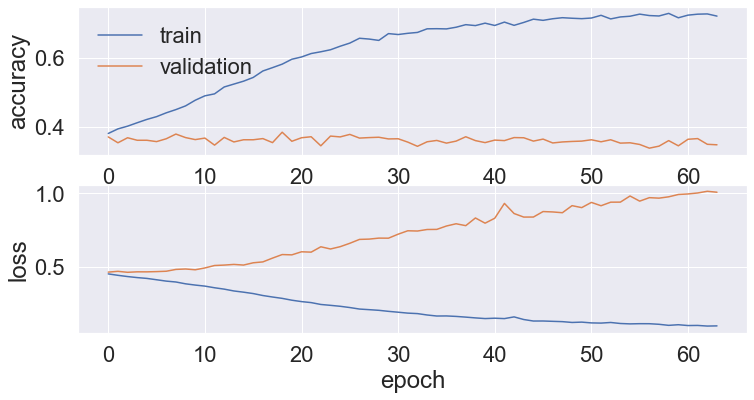

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()


Average binary classification scores:
  balanced_accuracy   0.59 +/- 0.04
  precision           0.39 +/- 0.17
  recall              0.33 +/- 0.13
  f1                  0.35 +/- 0.14

Multi-label classification metrics:
  accuracy      0.27
  precision     0.41
  recall        0.36
  f1            0.38
  hamming loss  1.24

ROC AUC scores:
  black     : 0.706
  death     : 0.682
  heavy     : 0.686
  power     : 0.656
  thrash    : 0.623
  macro-avg : 0.671 +/- 0.029


array([0.01007006, 0.08801511, 0.02914885, 0.08763492, 0.02120841])

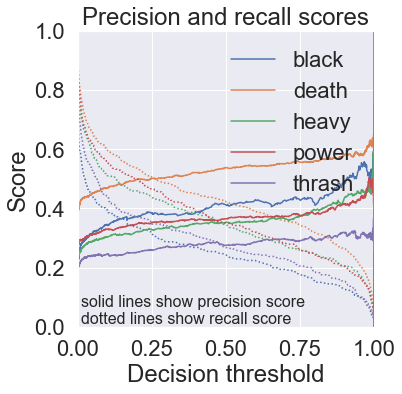

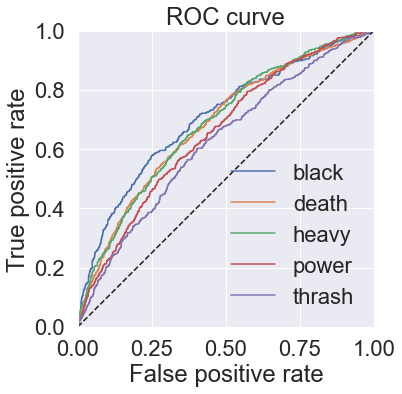

In [63]:
mlc = MultiLabelClassification(y_test, pred=y_pred, labels=labels)
mlc.print_report()
mlc.plot_precision_recall_curve()
mlc.plot_roc_curve()
mlc.best_thresholds()

In [64]:
mlc_tuned = MultiLabelClassification(y_test, pred=y_pred, labels=labels, threshold=mlc.best_thresholds())
mlc_tuned.print_report()


Average binary classification scores:
  balanced_accuracy   0.63 +/- 0.04
  precision           0.32 +/- 0.16
  recall              0.60 +/- 0.05
  f1                  0.41 +/- 0.13

Multi-label classification metrics:
  accuracy      0.31
  precision     0.34
  recall        0.61
  f1            0.43
  hamming loss  1.77

ROC AUC scores:
  black     : 0.706
  death     : 0.682
  heavy     : 0.686
  power     : 0.656
  thrash    : 0.623
  macro-avg : 0.671 +/- 0.029


In [65]:
y_pred.round().astype(int)[:20]

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [66]:
mlc_tuned.pred_class[:20]

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0]])

In [67]:
y_test[:20]

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0]], dtype=int64)